### Plotting the ADCP spectra

In [3]:
import numpy as np
import scipy.io as io
import sys
sys.path.append("../src/")

import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 19 days


In [4]:
plt.rcParams.update({'font.size': 25, 'legend.handlelength'  : 1.5
    , 'legend.markerscale': 1.})
plt.rc('xtick', labelsize=25) 
plt.rc('ytick', labelsize=25)

In [5]:
lw1=4
aph=.7
sc = 20.

In [6]:
import dp_map
dpmap = dp_map.drake_passage_map(fig_label="a",fig_title="ADCP")
m = dpmap.m

In [7]:
# dataset
data = np.load('outputs/mean_currents3.npz')
xgm,ygm = m(data['xg'],data['yg'])

fronts = Dataset('outputs/SO_polar_fronts.v3.nc','r') 
lon_fronts = np.array(fronts.variables['lon'][:])
lat_saf = np.array(fronts.variables['latSAF'][:,:])
lat_pf = np.array(fronts.variables['latPF'][:,:])
time_fronts = np.array(fronts.variables['time'][:])
lon_fronts2 = np.repeat(lon_fronts,time_fronts.size).reshape(time_fronts.size,lon_fronts.size) 

lat_pfm = np.nanmean(lat_pf,axis=0)
lat_pfstd = np.nanstd(lat_pf,axis=0)
xpf,ypf=m(lon_fronts,lat_pfm)
xpfl,ypfl=m(lon_fronts,lat_pfm-lat_pfstd)
xpfu,ypfu=m(lon_fronts,lat_pfm+lat_pfstd)

# Lenn et al. 2008 Polar fronts
lenn = io.loadmat('outputs/lenn_polar',squeeze_me=True,struct_as_record=False)

xlm,ylm = m(lenn['xip'],lenn['yipm'])
xlu,ylu = m(lenn['xip'],lenn['yipm']+lenn['yips'])
xll,yll = m(lenn['xip'],lenn['yipm']-lenn['yips'])

/Users/crocha/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:598: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/crocha/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1057: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


In [8]:
# masking
U26 = np.ma.masked_array(data['U26'],data['NDOF26']<5)
V26 = np.ma.masked_array(data['V26'],data['NDOF26']<5)
var_U26 = np.ma.masked_array(data['var_U26'],data['NDOF26']<5)
var_V26 = np.ma.masked_array(data['var_V26'],data['NDOF26']<5)
var26=(var_U26+var_V26)/2.
e26 = var_U26/var_V26; f = (e26<1.); #e26[f] = 1./e26[f]
e26s = float((e26.mask == False).sum())

Topography

In [10]:
topo = np.load("../topo/topo_dp.npz")
lont,latt,zt = topo['lon'],topo['lat'],topo['topo']
dec = 2
lont = lont[::dec]
latt = latt[::dec]
zt = zt[::dec,::dec]
lonti,latti = np.meshgrid(lont,latt)
xgt,ygt = m(lonti,latti)

In [55]:
import matplotlib.gridspec as gridspec

/Users/crocha/anaconda/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/Users/crocha/anaconda/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


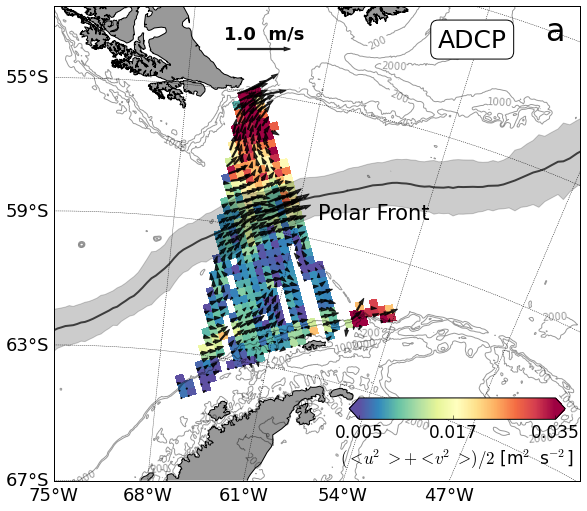

In [12]:
fig=plt.figure(facecolor='w', figsize=(12.,8.5))

cs = m.contour(xgt,ygt,-zt,np.array([200,1000,2000]),colors='k',alpha=.4)
plt.clabel(cs,inline=1,fontsize=10,fmt='%i')

pc = m.pcolor(xgm,ygm,var26,cmap='Spectral_r',vmin=0.005,vmax=0.03)

Q = m.quiver(xgm,ygm,U26,V26,color='k',scale=10,linewidths=1.,alpha=.8)


# quiver legend
qk = plt.quiverkey(Q, .4, .91, 1., '1.0  m/s',color='k',\
                   fontproperties={'weight': 'bold','size': '18'})

m.plot(xpf,ypf,'k',linewidth=2.,alpha=.7)
plt.fill_between(xpf,ypfl,ypfu, color='k', alpha=0.2)
plt.text(884397.07, 876462.09,'Polar Front',fontsize=21)

m.fillcontinents(color='.60',lake_color='none')
m.drawcoastlines()

dpmap.draw_par_mer()
dpmap.set_label(pos=(1650212,1475371))
dpmap.set_title(pos=(1400212,1475371))

axColor = plt.axes([.55,.225,.25,.035])
cb = plt.colorbar(pc, cax = axColor, orientation="horizontal",
                  extend='both')

cb.set_label(u'$(<u^2>+<v^2>)/2$ [m$^2$ s$^{-2}$]',fontsize=17)
cb.set_ticks(np.array([0.005,0.017,0.035]))
cb.ax.tick_params(labelsize=17) 

plt.savefig('figs/adcp_var26',dpi=300,bbox_inches='tight')